# Predicción de categoria de productos

### Links

- [Text Classification with BERT in PyTorch](https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f)
- [BERT models](https://huggingface.co/models)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn as sns

import numpy  as np
import pandas as pd

import torch
from   torch import nn
from   torch.optim import Adam
    
import logging

import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [3]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'1.12.1+cu116'

In [6]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-24 15:49:31,115 - INFO - cuda:0


In [7]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

## Funciones Helper

In [8]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

label_by_class = lambda df: {row['branch_seq']: row['branch'] for _, row in df[['branch_seq', 'branch']].drop_duplicates().iterrows() }

## Parametros

Fijamos la semilla para todas las librerias:

In [9]:
set_seed(42)

Definimos el modelo BERT preentrenado a utilizar. Este es una capa/module mas de nuestro modelo.

In [10]:
# BERT_MODEL ='bert-base-cased'
BERT_MODEL ='bert-base-uncased'
# BERT_MODEL = 'bert-large-uncased'
# BERT_MODEL ='distilbert-base-uncased'

Definimos los paths del dataset y pesos del modelo:

In [11]:
DATASET_PATH       = '../../datasets/fashion-outfits'
IMAGES_PATH        = '../../datasets/fashion-outfits/images'
WEIGHTS_PATH       = '../../weights'
MODEL_WEIGHTS_PATH = f'{WEIGHTS_PATH}/{BERT_MODEL}.h5'

In [12]:
TRAIN = True

In [13]:
!mkdir -p {WEIGHTS_PATH}

## Cargar dataset

In [14]:
train_set = pd.read_csv(f'{DATASET_PATH}/train.csv').drop_duplicates()
val_set   = pd.read_csv(f'{DATASET_PATH}/val.csv').drop_duplicates()
test_set  = pd.read_csv(f'{DATASET_PATH}/test.csv').drop_duplicates()

Nota: Por alguna randon tenemos algun valor lon en la description. Revisar?

In [15]:
train_set.head()

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq,features
0,16912282,accessories,hats,n/d,smiley medusa cap,"[multicolour, silk, panelled design, signature...",versace,men,['Silk' 'Cotton'],accessories~hats~n/d,29,16/91/22/82/16912282.jpg,1,description: smiley medusa cap. gender: men. b...
1,16688136,clothing,tops,blouses,ruffled-lace halterneck top,"[rose pink, silk, ruffled detailing, lace deta...",blumarine,women,['Polyester' 'Spandex/Elastane' 'Polyamide' 'S...,clothing~tops~blouses,33,16/68/81/36/16688136.jpg,74,description: ruffled-lace halterneck top. gend...
2,16557444,shoes,sandals,n/d,double strap flat sandals,"[black, leather, open toe, branded insole, buc...",alaïa,women,['Leather' 'Rubber'],shoes~sandals~n/d,25,16/55/74/44/16557444.jpg,104,description: double strap flat sandals. gender...
3,16671785,clothing,jackets,padded & down jackets,panelled puffer jacket,"[navy blue, quilted, panelled design, two side...",paul & shark,men,['Polyester' 'Nylon'],clothing~jackets~padded & down jackets,28,16/67/17/85/16671785.jpg,38,description: panelled puffer jacket. gender: m...
4,17338230,clothing,sweaters & knitwear,hoodies,logo-embroidered hoodie,"[petrol blue, cotton-blend, drawstring hood, e...",balenciaga,men,['Polyester' 'Cotton'],clothing~sweaters & knitwear~hoodies,33,17/33/82/30/17338230.jpg,69,description: logo-embroidered hoodie. gender: ...


In [17]:
train_set['features'] = train_set['features'].apply(str)
val_set  ['features'] = val_set  ['features'].apply(str)
test_set ['features'] = test_set ['features'].apply(str)

Tamaño máximo de la secuencia de entrada:

In [18]:
max_length = 2 + train_set['tokens_count'].max()
max_length

133

Definimos el tokenizer y los dataset para tran, validation y test:

In [19]:
tokenizer     = ml.Tokenizer(BERT_MODEL, padding = 'max_length', max_length = max_length)

In [20]:
train_dataset = dt.BertDataset(train_set, feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
val_dataset   = dt.BertDataset(val_set,   feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)
test_dataset  = dt.BertDataset(test_set,  feature_col = 'features', target_col = 'branch_seq', tokenizer = tokenizer)

## Preparando el modelo

Cantidad de clases a predecir:

In [20]:
len(train_set['branch_seq'].unique())

107

In [21]:
n_classes = train_set['branch_seq'].max() + 1
n_classes

107

In [22]:
classifier = ml.BertClassifier(output_dim = n_classes, model = BERT_MODEL, dropout = 0, hiden_state_dim= 768)

## Entrenamiento

In [23]:
model = ml.BertModel(classifier, batch_size = 50, criterion = nn.CrossEntropyLoss())

In [24]:
LR     = 0.00001
EPOCHS = 10

if TRAIN:
    model.fit(
        train_dataset, 
        val_dataset = val_dataset,
        optimizer   = Adam(classifier.parameters(), lr = LR),
        epochs      = EPOCHS
    )

2022-09-24 14:12:05,882 - INFO - Time: 0:08:28.77 | Epoch: 1 | Train(loss: 0.045054, acc: 57.12%) | Val(loss: 0.018946, acc: 78.52%) | acc diff: 21.40%
2022-09-24 14:20:34,832 - INFO - Time: 0:08:28.95 | Epoch: 2 | Train(loss: 0.016051, acc: 80.12%) | Val(loss: 0.013623, acc: 81.05%) | acc diff: 0.93%
2022-09-24 14:29:03,660 - INFO - Time: 0:08:28.83 | Epoch: 3 | Train(loss: 0.012754, acc: 82.31%) | Val(loss: 0.012532, acc: 82.04%) | acc diff: 0.27%
2022-09-24 14:37:32,482 - INFO - Time: 0:08:28.82 | Epoch: 4 | Train(loss: 0.011396, acc: 83.63%) | Val(loss: 0.012110, acc: 82.26%) | acc diff: 1.36%
2022-09-24 14:46:01,574 - INFO - Time: 0:08:29.09 | Epoch: 5 | Train(loss: 0.010522, acc: 84.60%) | Val(loss: 0.011669, acc: 82.91%) | acc diff: 1.70%
2022-09-24 14:54:30,534 - INFO - Time: 0:08:28.96 | Epoch: 6 | Train(loss: 0.009714, acc: 85.54%) | Val(loss: 0.011753, acc: 82.26%) | acc diff: 3.28%
2022-09-24 15:02:59,624 - INFO - Time: 0:08:29.09 | Epoch: 7 | Train(loss: 0.008943, acc: 86.

In [25]:
if TRAIN:
    classifier.save(MODEL_WEIGHTS_PATH)

## Evaluación

In [26]:
classifier.load(MODEL_WEIGHTS_PATH)

In [27]:
summary = model.validate(test_dataset)
summary.show()

Accuracy: 82.48%, Loss: 0.012515


<Figure size 2500x2500 with 2 Axes>

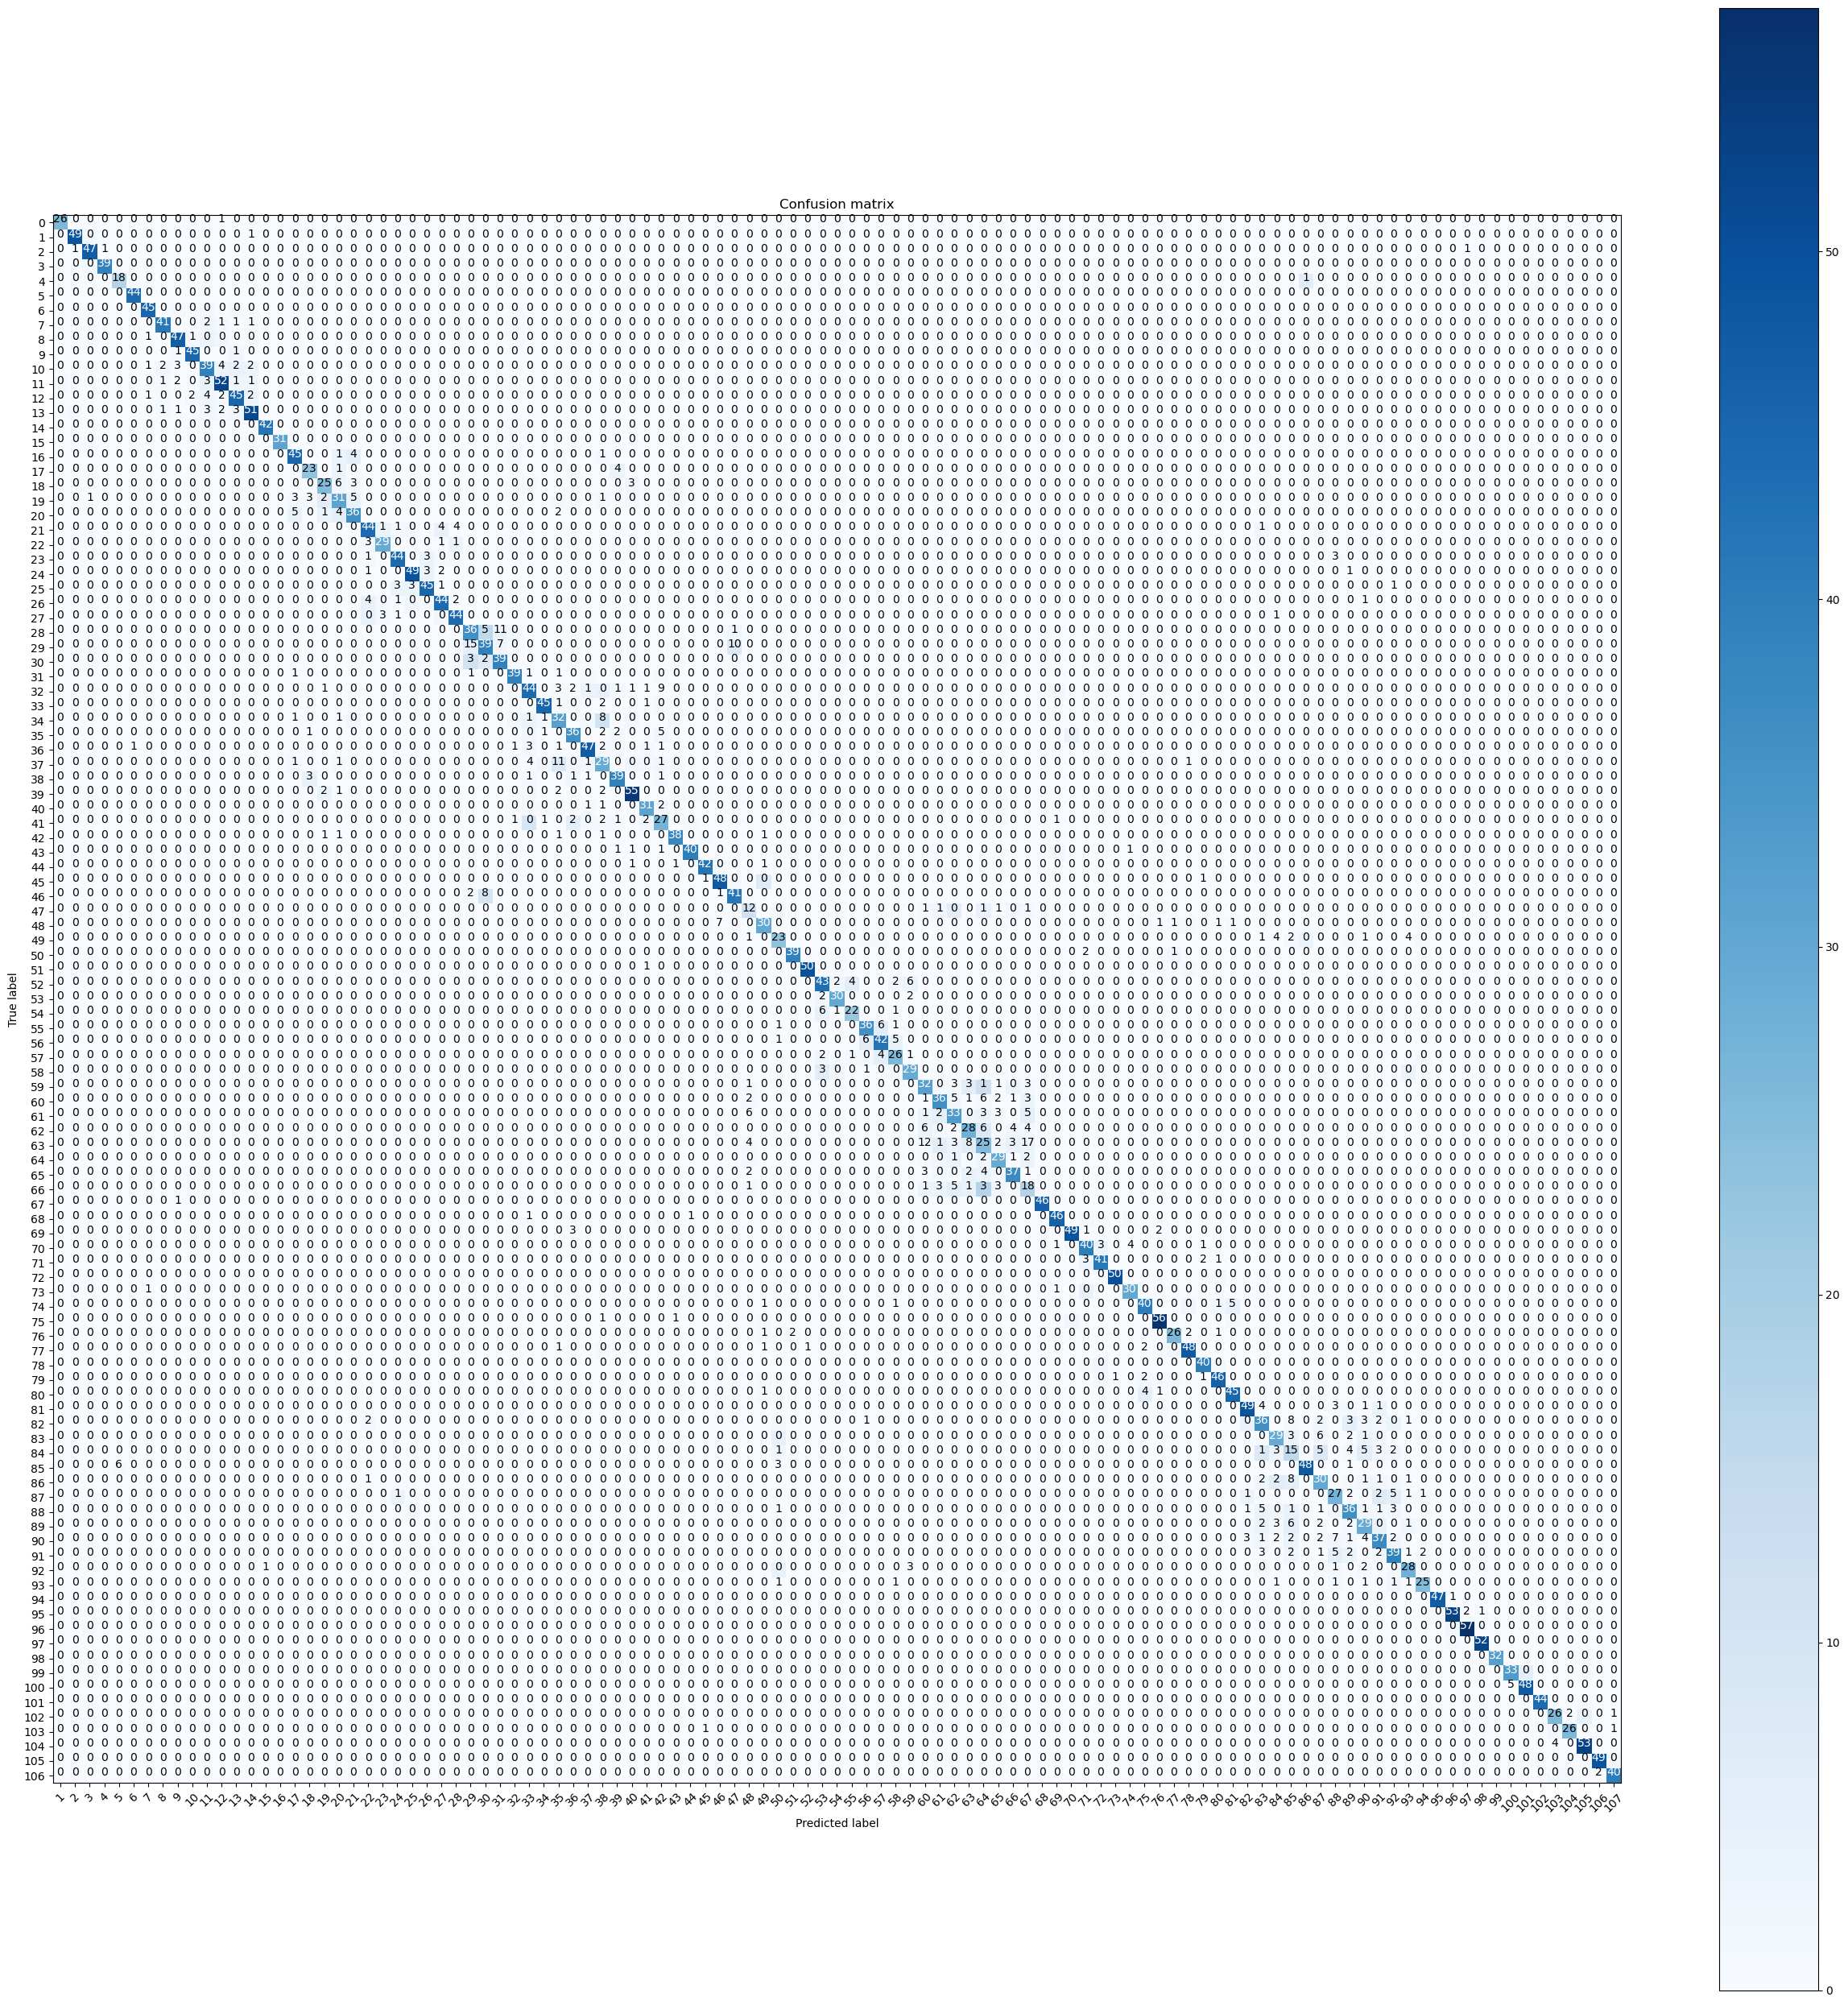

                                                      precision    recall  f1-score   support

                               accessories~belts~n/d       0.96      1.00      0.98        26
                                accessories~hats~n/d       0.98      0.98      0.98        50
                             accessories~scarves~n/d       0.94      0.98      0.96        48
                          accessories~sunglasses~n/d       1.00      0.97      0.99        40
activewear~performance trousers~performance leggings       0.95      0.75      0.84        24
                                  bags~backpacks~n/d       1.00      0.98      0.99        45
                                  bags~belt bags~n/d       1.00      0.92      0.96        49
                                bags~bucket bags~n/d       0.89      0.91      0.90        45
                                bags~clutch bags~n/d       0.96      0.85      0.90        55
                             bags~messenger bags~n/d       

In [28]:
# summary.show_sample_metrics(0)
result = summary.plot_metrics(label_by_class = label_by_class(train_set))

In [29]:
report_generator = ml.FailReportGenerator(
    tokenizer, 
    test_set, 
    test_dataset, 
    summary.targets, 
    summary.predictions,
    IMAGES_PATH
)

report = report_generator()

report.to_csv(f'{DATASET_PATH}/bet-model-fail-report.csv', index=False)

Total Fails: 17.52%


Ahora filtramos el reporte solo para aquellas clases que tiene un F1Score menor al 69%:

In [30]:
worts_classes = [
    'clothing~coats~oversized coats',
    'clothing~coats~single breasted coats',
    'clothing~dresses~cocktail & party dresses',
    'clothing~dresses~day dresses',
    'clothing~dresses~evening dresses',
    'clothing~jackets~cropped jackets',
    'clothing~jackets~fitted jackets',
    'clothing~jackets~lightweight jackets',
    'clothing~jackets~oversized jackets',
    'clothing~jackets~sport jackets & windbreakers',
    'clothing~knitwear~knitted skirts',
    'clothing~shorts~knee-length shorts',
    'clothing~shorts~tailored shorts',
    'clothing~skirts~asymmetric & draped skirts',
    'clothing~skirts~fitted skirts',
    'clothing~skirts~full skirts',
    'clothing~skirts~high-waisted skirts',
    'clothing~skirts~pencil skirts',
    'clothing~skirts~straight skirts',
    'clothing~trousers~flared trousers',
    'clothing~trousers~high-waisted trousers',
    'clothing~trousers~regular & straight-leg trousers',
    'clothing~trousers~skinny trousers',
    'clothing~trousers~slim-fit trousers',
    'clothing~trousers~straight trousers'
]               
                
report = report[report['true_class'].isin(worts_classes)].reset_index(drop=True)

In [31]:
report.shape, test_set.shape

((394, 5), (4944, 13))

In [32]:
ut.display_html(report)

,description,true_class,true_image,pred_class,pred_image
0,"description : silk wrap mini skirt. gender : women. brand : michelle mason. materials : silk. highlights : carbon black, silk, wraparound style, side tie fastening, thigh - length",clothing~skirts~asymmetric & draped skirts,,clothing~skirts~straight skirts,
1,"description : drawstring tailored trousers. gender : women. brand : semicouture. materials : viscose, virgin wool, spandex / elastane, polyester. highlights : grey, virgin wool blend, straight leg, drawstring fastening, two side slit pockets, two rear welt pockets",clothing~trousers~high-waisted trousers,,clothing~trousers~tailored trousers,
2,"description : ruffled pleated midi dress. gender : women. brand : p. a. r. o. s. h.. materials : polyester. highlights : red, ruffled detailing, fully pleated, round neck, sleeveless, mid - length",clothing~dresses~evening dresses,,clothing~dresses~day dresses,
3,"description : mark slim - cut tailored trousers. gender : women. brand : maximilian. materials : wool, cupro. highlights : black, wool - blend, high waist, belt loops, concealed front fastening, slip pockets to the sides, slim cut, ankle - length",clothing~trousers~slim-fit trousers,,clothing~trousers~tailored trousers,
4,"description : embroidered logo culottes. gender : women. brand : sport b. by agnes b.. materials : linen / flax, tencel, cotton. highlights : green, linen blend, embroidered logo to the side, elasticated waistband, two side patch pockets, wide leg, knee - length",clothing~shorts~knee-length shorts,,clothing~trousers~cropped trousers,
5,"description : animal print wrap skirt. gender : women. brand : john richmond. materials : cupro, viscose, wool, acrylic, other fibres, polyester. highlights : leopard, animal print, wrap design, rear zip fastening, thigh - length",clothing~skirts~asymmetric & draped skirts,,clothing~skirts~straight skirts,
6,"description : button - front midi skirt. gender : women. brand : reinaldo lourenco. materials : cotton, spandex / elastane. highlights : bright red ;, stretch - cotton ;, high waist ;, snap - button fastening ;, off - centre front buckle fastening ;, two side zip - fastening pockets ;, mid - length.",clothing~skirts~straight skirts,,clothing~skirts~high-waisted skirts,
7,description : polka dot scalloped maxi skirt. gender : women. brand : rejina pyo. materials : polyester,clothing~skirts~full skirts,,clothing~skirts~high-waisted skirts,
8,"description : asymmetric maxi skirt. gender : women. brand : p. a. r. o. s. h.. materials : polyester. highlights : jet - black, asymmetric design, high - waisted, maxi",clothing~skirts~high-waisted skirts,,clothing~skirts~asymmetric & draped skirts,
9,"description : mybody puff - shoulder dress. gender : women. brand : az factory. materials : viscose, lycra, polyester. highlights : red, perforated underarms, patterned design, removable gold chain, off - shoulder, v - neck, long puff sleeves, anatoknit is az factory ’ s new innovative knitwear technology composed of enka® viscose and lycra. this ultra - soft and flexible textile is specially engineered to strategically sculpt and support the body, while allowing for breathability and comfortable movement., the compression effect on this style is strong. we",clothing~dresses~cocktail & party dresses,,clothing~dresses~day dresses,
